In [14]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Функции определения Среднеквадратичной ошибки и Среднеквадратичной логарифмической ошибки

In [15]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def rmsle(y_true, y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [51]:
def cleaning(data):
    categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
    numerical_columns   = [c for c in data.columns if (data[c].dtype.name != 'object' and c != 'SalePrice')]
    answer_column = [c for c in data.columns if c == 'SalePrice']
    
    #заполняем пустые числовые медианным значением
    data = data.fillna(data.median(axis=0), axis=0)
    
    #заполняем пустые НЕчисловые самым частым значением
    data_describe = data.describe(include=[object])
    for c in categorical_columns:                   
        data[c] = data[c].fillna(data_describe[c]['top'])
    
    #переводим все НЕчисловые признаки в числовые
    binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2] #бинарные
    nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2] #небинарные
    #заменим значения в бинарных колонках на 0 и 1
    for c in binary_columns:
        top = data_describe[c]['top']
        top_items = data[c] == top #промежуточные данные, равные тем, которые являются популярнейшими в колонке
        data.loc[top_items, c] = 0 #делаем их значения 0
        data.loc[np.logical_not(top_items), c] = 1 #остальные 1
    #print(data[nonbinary_columns])
    #Здесь мы создали лишние фичи, разделив НЕчисловые небинарные на несколько, по которм мы говорим, относится ли данная строка
    #к этому признаку или нет
    data_nonbinary = pd.get_dummies(data[nonbinary_columns])
    #print(data_nonbinary)
    #начинаем нормализацию численных признаков
    data_numerical = data[numerical_columns]
    data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
    data_answer = data[answer_column] #не требуется нормализация
    #соединяем всё в таблицу
    data = pd.concat((data_numerical, data[binary_columns], data_nonbinary, data_answer), axis=1)
    data = pd.DataFrame(data, dtype=float)
    return data

Забираем данные из файла тренировочных данных и сразу "чистим", удаляя Nan-ы, заменяя их на популярнейшие в столбце значения (для усреднения выборки, хотя это не оптимальный вариант, но лучше я не придумал), и заменя все НЕчисловые значения на 0 и 1, разделив некоторые фичи на несколько отдельных столбцов

In [53]:
#data #Смотрим на наш изначальный датасет
#Понимаем, что нам не нравятся Nan-ы
#Сейчас мы их заменим на самые популярные записи в соответствующих столбцах, используя функцию выше

In [52]:
data = pd.read_csv('D:\Artem\Documents\BMSTU\ML\LR3\\train.csv')
data = cleaning(data)

Видим, что количество колонок значительно увеличилось, примерно в 6 раз, что замедляет программу, однако это позволяет полноценно учитывать НЕчисловые признаки наравне с числовыми

In [56]:
#data
#я принял общую площадь равной сумме площадей с 1 и 2 этажа, если она меньше суммы оных
data.loc[data['TotalBsmtSF'] < data['1stFlrSF'] + data['2ndFlrSF'], 'TotalBsmtSF'] = data['1stFlrSF'] + data['2ndFlrSF']
data.drop(col, inplace = True, axis = 1)

In [57]:
corr = data.corr()

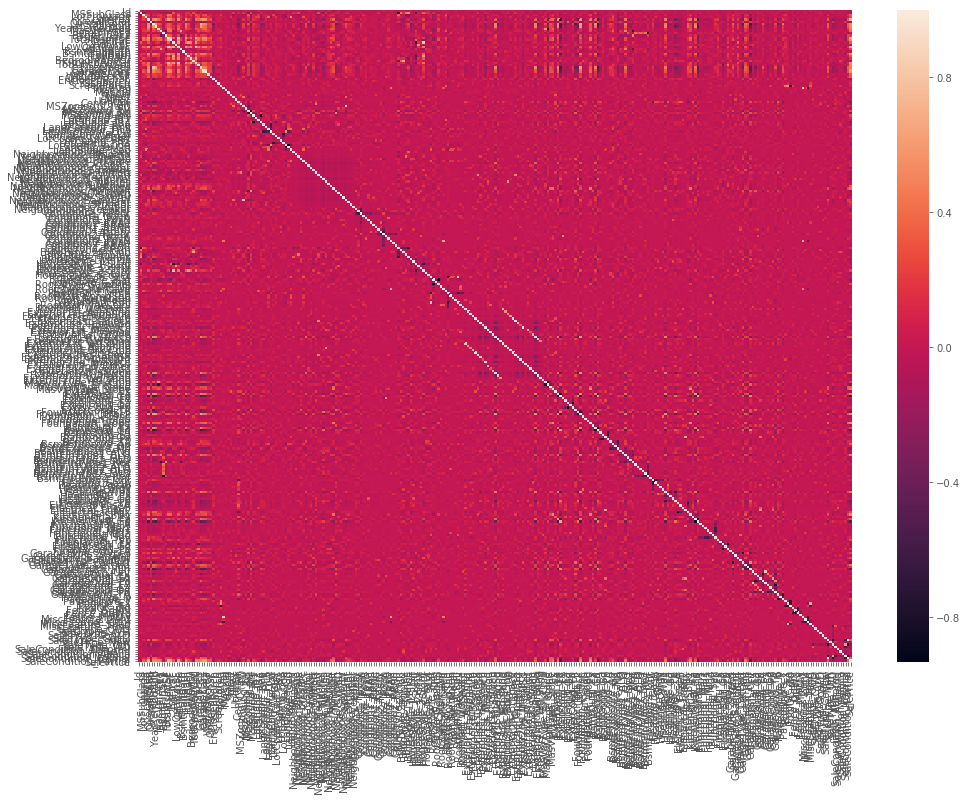

In [58]:
_, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)
#ЦЭ ЖЭСТЬ!!!

Смотрим на то, как фичи влияют на цену, с помощью корреляции, а не вручную изучая каждый из 250-ти признаков. Выберу те, которые наиболее сильно влияют на цену, на всякий случай, сохранив данные, которые удалю из самого датасета

In [65]:
drop_cols = []
for col in corr.columns:
    if (abs(corr[col]['SalePrice']) < 0.3  and col != 'SalePrice'):
        drop_cols.append(col)
        data.drop(col, inplace = True, axis = 1)

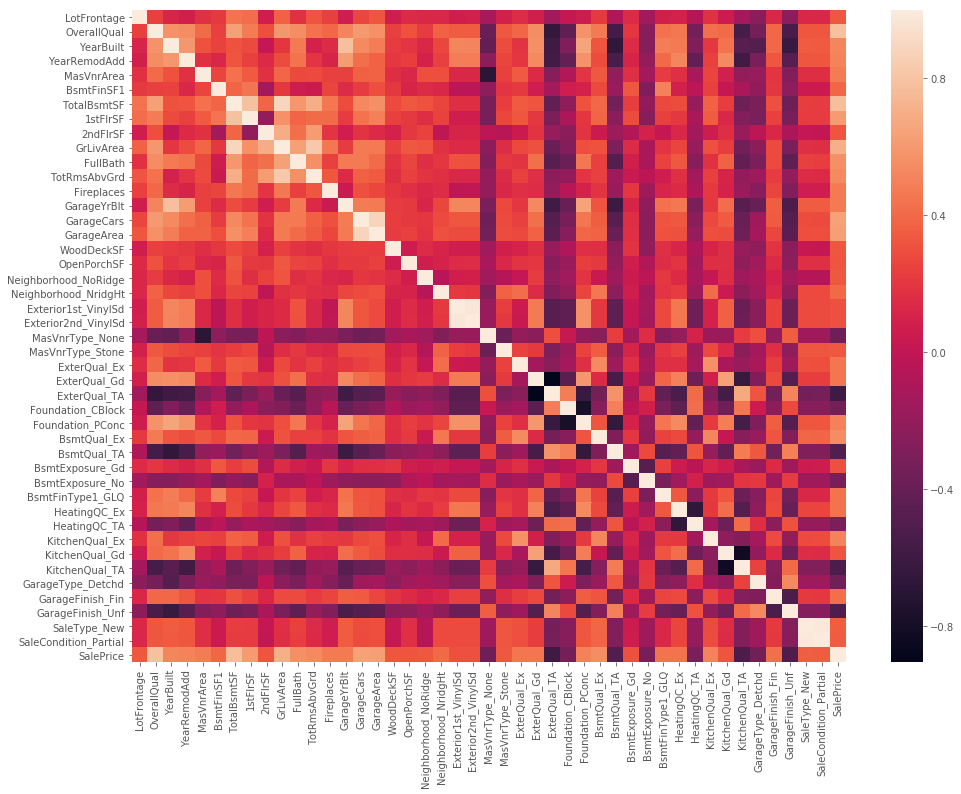

In [66]:
corr = data.corr()
_, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)

In [67]:
data

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_TA,GarageType_Detchd,GarageFinish_Fin,GarageFinish_Unf,SaleType_New,SaleCondition_Partial,SalePrice
0,-0.220799,0.651256,1.050634,0.878367,0.513928,0.575228,0.368292,-0.793162,1.161454,0.370207,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,208500.0
1,0.460162,-0.071812,0.156680,-0.429430,-0.570555,1.171591,0.466305,0.257052,-0.794891,-0.482347,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,181500.0
2,-0.084607,0.651256,0.984415,0.829930,0.325803,0.092875,0.561332,-0.627611,1.188943,0.514836,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,223500.0
3,-0.447787,0.651256,-1.862993,-0.720051,-0.570555,-0.499103,0.415400,-0.521555,0.936955,0.383528,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,140000.0
4,0.641752,1.374324,0.951306,0.733056,1.366021,0.463410,1.571727,-0.045596,1.617323,1.298881,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,250000.0
5,0.687149,-0.794879,0.719540,0.490872,-0.570555,0.632233,-0.446663,-0.948366,0.501703,-0.292045,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,143000.0
6,0.233175,1.374324,1.083743,0.975241,0.458597,2.028862,1.432785,1.374522,-0.794891,0.339758,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,307000.0
7,-0.039210,0.651256,0.057352,-0.574741,0.757383,0.910682,1.313075,-0.143892,1.456967,1.093354,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,200000.0
8,-0.856363,0.651256,-1.333243,-1.688790,-0.570555,-0.972685,0.564028,-0.363764,0.927792,0.492000,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,129900.0
9,-0.901761,-0.794879,-1.068368,-1.688790,-0.570555,0.893142,-0.151422,-0.221494,-0.794891,-0.834405,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,118000.0


Осталось 45 колонок из 250, неплохо, я считаю

А теперь мы все это в линейную регрессию, и посмотрим, что вышло

In [72]:
X = data.drop('SalePrice', axis = 1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = X_train
y_train = y_train
X_test = X_test
y_test = y_test

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)